In [27]:
from NumbaLSODA import lsoda_sig, lsoda
from numba import njit, cfunc
from scipy.integrate import solve_ivp 
import numpy as np
from matplotlib import pyplot as plt

In [31]:
@cfunc(lsoda_sig)
def f(t, u, du, p):
    du[0] = u[0]-u[0]*u[1]
    du[1] = u[0]*u[1]-u[1]

@njit
def f_scipy(t, u):
    return np.array([u[0]-u[0]*u[1],u[0]*u[1]-u[1]])

In [32]:
funcptr = f.address
u0 = np.array([5.,0.8])
data = np.array([1.0])
t_eval = np.linspace(0.0,50.0,1000)

In [75]:
usol, success = lsoda(funcptr, u0, t_eval, data)

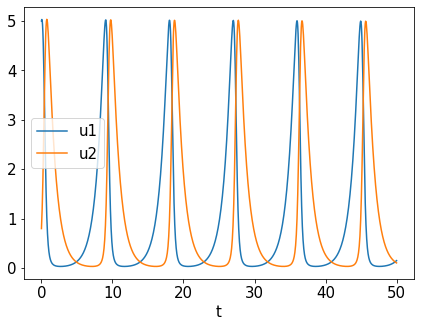

In [76]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[7,5])

ax.plot(t_eval,usol[:,0],label='u1')
ax.plot(t_eval,usol[:,1],label='u2')
ax.legend()
ax.set_xlabel('t')

plt.show()

In [77]:
# Check that NumbaLSODA and scipy match.

# NumbaLSODA
usol, success = lsoda(funcptr, u0, t_eval, data, rtol = 1e-9, atol = 1e-30)

# scipy
t_span = [min(t_eval),max(t_eval)]
sol = solve_ivp(f_scipy, t_span, u0, t_eval = t_eval,\
                rtol = 1e-9, atol = 1e-30, method='LSODA')
print(np.all(np.isclose(sol.y.T,usol)))

True


In [78]:
t_nb = %timeit -o usol, success = lsoda(funcptr, u0, t_eval, data, rtol = 1e-6, atol = 1e-30)
t_sp = %timeit -o sol = solve_ivp(f_scipy, t_span, u0, t_eval = t_eval,\
                                  rtol = 1e-6, atol = 1e-30, method='LSODA')

print("\nscipy took "+'%i'%(t_sp.average/t_nb.average)+" times longer than NumbaLSODA")

200 µs ± 2.94 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
58.2 ms ± 351 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

scipy took 290 times longer than NumbaLSODA


In [79]:
# NumbaLSODA within jit compiled function works
@njit
def test():
    usol, success = lsoda(funcptr, u0, t_eval, data)
    return usol
test()

array([[5.        , 0.8       ],
       [5.02801788, 0.97855571],
       [5.00657991, 1.19693864],
       ...,
       [0.1390893 , 0.1149374 ],
       [0.1454087 , 0.1101119 ],
       [0.15204821, 0.10552706]])

In [80]:
# scipy within jit compiled function does not work
@njit
def test_sp():
    sol = solve_ivp(f_scipy, t_span, u0, t_eval = t_eval, method='LSODA')
    return sol
test_sp()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'solve_ivp':[0m [1m[1mcannot determine Numba type of <class 'function'>[0m
[1m
File "<ipython-input-80-5c5792bf243b>", line 4:[0m
[1mdef test_sp():
[1m    sol = solve_ivp(f_scipy, t_span, u0, t_eval = t_eval, method='LSODA')
[0m    [1m^[0m[0m
[0m